# Game of Thrones NLP

In [410]:
# GENERAL
import numpy as np
import pandas as pd
import re
from collections import Counter

# GRAPHICS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NLP
from nltk import word_tokenize
from nltk import bigrams
from nltk import trigrams
from nltk import ngrams
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import collocations

# MODELING
from sklearn import metrics, tree, linear_model, neighbors, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

## Can we train a model to identify which GoT character is saying a line from the show?

## Can we use NLP to identify major characters' "catchphrases" (distinct ngrams)?

## 1. Load, clean GoT script data

### NOTE: all scripts acquired here https://gameofthronesfanon.fandom.com/wiki/Category:Transcripts

### 1.1 Test on a single script

In [506]:
# Load unabridged script
original_script = open('GoT_NLP data/GoT_S02E01.txt').read()

In [507]:
# Split into lines
script = original_script.split("\n\n")

In [508]:
# Generate script of lines only
script_lines = []

for i in range(0,len(script)):
    if ":" in script[i]: # If a dialogue line - this may miss a few lines in the end but that's OK
        script_lines.append(script[i])

print("Full script:", len(script), "->", "Dialogue lines:", len(script_lines))

#     if script[i][0] !="[" and script[i][0:5] != "TITLE" or ":" in line:
#             if "]" in line and ":" not in line:


Full script: 497 -> Dialogue lines: 378


In [510]:
# Remove all parentheses, square brackets
p = 0
sb = 0

for i in range(0, len(script_lines)):
    if "(" in script_lines[i]:
#         print(sript_lines[i])
        script_lines[i] = re.sub(" \(.+?\)","", script_lines[i])
        p += 1
    if "[" in script_lines[i]:
#         print(script_lines[i])
        script_lines[i] = re.sub(" \[.+?\]","", script_lines[i])
#         print(script_lines[i])
        sb += 1
        
print(p, "parentheses removed.", sb, "square brackets removed.")

62 parentheses removed. 0 square brackets removed.


In [511]:
# Separate lines into character, line
characters = []
lines = []

for line in script_lines:
    characters.append(line.split(":")[0])
    lines.append(line.split(":")[1].strip()) # Strip leading whitespace

In [512]:
# Create and populate df
df = pd.DataFrame()
df["Characters"] = characters
df["Lines"] = lines
display(df)

,Characters,Lines
0,JOFFREY,"Well struck… Well struck, Dog."
1,JOFFREY,Did you like that?
2,SANSA,"It was well struck, Your Grace."
3,JOFFREY,I already said it was well struck.
4,SANSA,"Yes, Your Grace."
5,JOFFREY,Who's next?
6,ANNOUNCER,"Lothor Brune, freerider in the service of Lord..."
7,ANNOUNCER,Ser Dontos the Red of House Hollard.
8,ANNOUNCER,Ser Dontos the Red of House Hollard!
9,SER DONTOS,"Here I am.. Here I am.. Sorry, Your Grace.. My..."


Now we have a df consisting of character names and lines for each character. In time we will load this for all episodes.

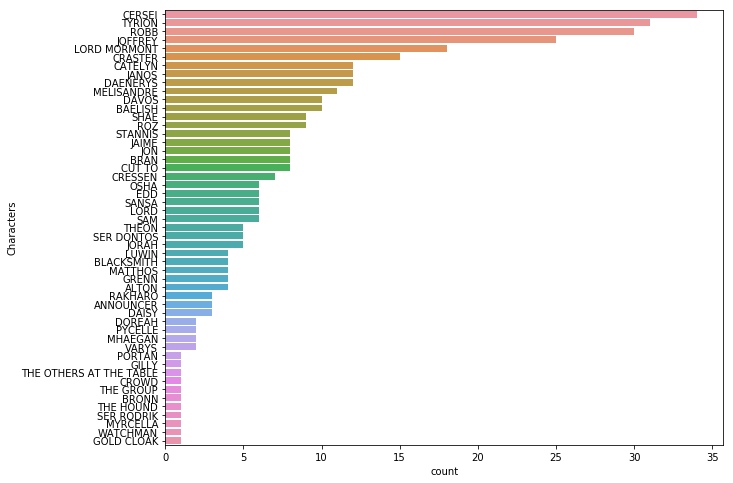

In [516]:
# Graph characters' line counts

order = df['Characters'].value_counts().index

plt.figure(figsize=(10,8))
sns.countplot(y = "Characters", data = df, order = order)
plt.show()

### 1.2 Find common n-grams for a character

In [411]:
# Add empty bigram, trigram columns to the df
df["Bigrams"] = ""
df["Trigrams"] = ""

# Add empty 4-gram, 5-gram columns to the df
df["Fourgrams"] = ""
df["Fivegrams"] = ""

In [412]:
# Use NLTK to find all bigrams, trigrams, fourgrams, fivegrams for each line
all_bigrams = []
all_trigrams = []
all_fourgrams = []
all_fivegrams = []

for i in df['Lines']:
    
    bgs = bigrams(i.split()) # 2-grams
    all_bigrams.append(list(bgs))
    
    tgs = trigrams(i.split()) # 3-grams
    all_trigrams.append(list(tgs))
    
    fourgrams = ngrams(i.split(), 4) # 4-grams
    all_fourgrams.append(list(fourgrams))
    
    fivegrams = ngrams(i.split(), 5) # 5-grams
    all_fivegrams.append(list(fivegrams))
    
df["Bigrams"] = all_bigrams
df["Trigrams"] = all_trigrams
df["Fourgrams"] = all_fourgrams
df["Fivegrams"] = all_fivegrams

In [414]:
# Check common bigrams, trigrams for a character (e.g. NED)
bigrams_NED = df[df['Characters']=="NED"]["Bigrams"].values
trigrams_NED = df[df['Characters']=="NED"]["Trigrams"].values
fourgrams_NED = df[df['Characters']=="NED"]["Fourgrams"].values
fivegrams_NED = df[df['Characters']=="NED"]["Fivegrams"].values

In [416]:
# Place all bigrams, trigrams for the character into a single list
all_bigrams_NED = []
all_trigrams_NED = []
all_fourgrams_NED = []
all_fivegrams_NED = []

for i in bigrams_NED:
    all_bigrams_NED += i

for i in trigrams_NED:
    all_trigrams_NED += i
    
for i in fourgrams_NED:
    all_fourgrams_NED += i

for i in fivegrams_NED:
    all_fivegrams_NED += i

    
# Print length of bigrams, trigrams
print(len(all_bigrams_NED), len(all_trigrams_NED), len(all_fourgrams_NED), len(all_fivegrams_NED))

352 303 259 222


In [418]:
# Get the most common n-grams for the character
bigram_counter_NED = Counter(all_bigrams_NED)
print(bigram_counter_NED.most_common(5), "\n")

trigram_counter_NED = Counter(all_trigrams_NED)
print(trigram_counter_NED.most_common(5), "\n")

fourgram_counter_NED = Counter(all_fourgrams_NED)
print(fourgram_counter_NED.most_common(5), "\n")

fivegram_counter_NED = Counter(all_fivegrams_NED)
print(fivegram_counter_NED.most_common(5), "\n")

[(('of', 'the'), 7), (('them', 'yourselves.'), 3), (('Your', 'Grace.'), 3), (('I', 'don’t'), 3), (('is', 'coming.'), 2)] 

[(('of', 'the', 'House'), 2), (('understand', 'why', 'I'), 2), (('I', 'don’t', 'fight'), 2), (('don’t', 'fight', 'in'), 2), (('And', 'which', 'one'), 1)] 

[(('I', 'don’t', 'fight', 'in'), 2), (('And', 'which', 'one', 'of'), 1), (('which', 'one', 'of', 'you'), 1), (('one', 'of', 'you', 'was'), 1), (('of', 'you', 'was', 'a'), 1)] 

[(('And', 'which', 'one', 'of', 'you'), 1), (('which', 'one', 'of', 'you', 'was'), 1), (('one', 'of', 'you', 'was', 'a'), 1), (('of', 'you', 'was', 'a', 'marksman'), 1), (('you', 'was', 'a', 'marksman', 'at'), 1)] 



Now we have a way of generating n-grams for each character. Once we load all episode transcripts we can make better use of this.

## 2. Load clean all GoT scripts

In [447]:
# Load unabridged scripts

original_script_2 = open('GoT_NLP data/GoT_S01E02.txt').read()

In [450]:
# Split into lines
script_2 = original_script_2.split("\n\n")
len(script_2)

577

In [451]:
script_2

["[Episode opens with KHAL DROGO's khalasar travelling through a field. DAENERYS and JORAH are shown on horseback. DAENERYS is apart from the main procession. JORAH goes over to her.]",
 'JORAH: You need to drink, child. And eat.',
 '[JORAH hands DAENERYS a piece of horse jerky.]',
 "DAENERYS: Isn't there anything else?",
 "JORAH: The Dothraki have two things in abundance: grass and horses. People can't live on grass.",
 '[Pause while DAENERYS eats the jerky].',
 "JORAH: In the Shadow Lands beyond Asshai, they say there are fields of ghost grass with stalks as pale as milk that glow in the night. It murders all other grass. The Dothraki believe that one day it will cover everything. That's the way the world will end.",
 '[Pause while DAENERYS looks uneasily at DROGO. JORAH looks from DROGO to her.]',
 "JORAH: It'll get easier.",
 '[DAENERYS looks unconvinced as they both rejoin the khalasar and resume riding.]',
 "[Scene shifts to the Dothraki camp, where various Dothraki are tending t

In [453]:
# Generate script of lines only
script_lines_2 = []

for i in range(0,len(script_2)):
    if ":" in script_2[i]: # If a dialogue line - this may miss a few lines in the end but that's OK
        script_lines_2.append(script_2[i])

print("Full script:", len(script_2), "->", "Dialogue lines:", len(script_lines_2))

#     if script[i][0] !="[" and script[i][0:5] != "TITLE" or ":" in line:
#             if "]" in line and ":" not in line:


Full script: 577 -> Dialogue lines: 391


In [454]:
script_lines_2

['JORAH: You need to drink, child. And eat.',
 "DAENERYS: Isn't there anything else?",
 "JORAH: The Dothraki have two things in abundance: grass and horses. People can't live on grass.",
 "JORAH: In the Shadow Lands beyond Asshai, they say there are fields of ghost grass with stalks as pale as milk that glow in the night. It murders all other grass. The Dothraki believe that one day it will cover everything. That's the way the world will end.",
 "JORAH: It'll get easier.",
 "JORAH: We're still not far from Pentos, Your Grace. Magister Illyrio has extended his hospitality. You'd be more comfortable there.",
 "VISERYS: I have no interest in hospitality or comfort. I'll stay with Drogo until he fulfils his end of the bargain and I have my crown.",
 'JORAH: As you wish, Your Grace.',
 'VISERYS: Well, Mormont, as brutish as this life is, I suppose it is preferable to beheading. What did Ned Stark want you for? Buying from a slaver?',
 'JORAH: Selling to one...some poachers I caught on my la